# FIT5149 S1 2021
# Assessment 1: Electric Rotor Temperature Prediction


Student information
- Family Name: Sunthornjittanon
- Given Name:  Pichaphop
- Student ID:  31258301
- Student email: psun0009@student.monash.edu

Programming Language: R 3.5.1 in Jupyter Notebook

R Libraries used:
- library(dplyr)
- library(psych)
- library(reshape2)
- library(ggplot2)
- library(lattice)
- library(GGally)
- library(caret)
- library(glmnet)
- library(leaps)
- library(gridExtra)
- library(car)

## Table of Contents

1. [Introduction](#sec_1)
3. [Exploratory Data Analysis](#sec_3)
3. [Methodology](#sec_4)
3. [Model Development](#sec_5)
3. [Results and discussion](#sec_6)
3. [Conclusion](#sec_7)
3. [References](#sec_8)

## 1. Introduction <a class="anchor" id="sec_1"></a>

In [1]:
# Load the libraries used in this workbook
options(warn = -1)

library(dplyr)
library(psych)
library(reshape2)
library(ggplot2)
library(lattice)
library(GGally)
library(caret)
library(glmnet)
library(leaps)
library(gridExtra)
library(car)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'ggplot2'

The following objects are masked from 'package:psych':

    %+%, alpha

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Attaching package: 'caret'

The following object is masked _by_ '.GlobalEnv':

    RMSE

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

Loading required package: carData

Attaching package: 'car'

The following object is masked from 'package:psych':

    logit

The following object is masked from 'package:dplyr':

    recode



## 2. Exploratory Data Analysis<a class="anchor" id="sec_3"></a>

### Read the data

In [2]:
# Load the dataset
pmsmdata <- read.csv('pmsm_temperature_data_A1_2021.csv')

### Exclude unused column and split testing-training data 

In [3]:
# Exclude the columns(stator_yoke,stator_winding) that should not be used, which was stated in the requirement
pmsmdata <- pmsmdata %>%
            select(-stator_yoke,-stator_winding,-stator_tooth)

In [4]:
# Split the data into test and train dataset

train_pmsm <- pmsmdata %>%
              filter(!profile_id %in% c(72,81)) %>%
              select(-profile_id)

test_pmsm <- pmsmdata %>%
              filter(profile_id %in% c(72,81)) %>%
              select(-profile_id)


### 2.1 Overview of the trainning dataset

In [5]:
# Show the dimensions and data structure
cat("The PMSM training data set has ", dim(train_pmsm)[1], "records and", dim(train_pmsm)[2],
    "attributes. The structure of the dataset is shown belown:\n\n")

str(train_pmsm)

# Show sample records
cat("\nThe sample records are")

head(train_pmsm)

# Summarise basic statistics in each attribute
cat("\n Basic Statistics in each column")
round(describe(train_pmsm), 4)

The PMSM training data set has  9652 records and 9 attributes. The structure of the dataset is shown belown:

'data.frame':	9652 obs. of  9 variables:
 $ ambient    : num  0.118 -0.555 -0.772 0.22 0.402 ...
 $ coolant    : num  -1.04 -1.09 -1.06 -1.08 -1.08 ...
 $ u_d        : num  -1.027 -1.226 0.299 -1.026 0.316 ...
 $ u_q        : num  0.925 0.513 0.956 0.928 -0.709 ...
 $ motor_speed: num  1.212 2.024 -0.14 1.212 -0.952 ...
 $ torque     : num  0.359 0.284 -0.259 0.357 -0.256 ...
 $ i_d        : num  -0.834 -1.364 1.029 -0.838 1.029 ...
 $ i_q        : num  0.323 0.234 -0.246 0.323 -0.246 ...
 $ pm         : num  -0.0883 0.7104 -1.5926 -0.1417 -1.9649 ...

The sample records are

ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm
0.1176819,-1.040829,-1.0267303,0.9250645,1.2124813,0.3586899,-0.8343090,0.3229330,-0.08831267
-0.5547717,-1.087189,-1.2258921,0.5125759,2.0241232,0.2841797,-1.3638294,0.2340145,0.71040170
-0.7722329,-1.063652,0.2988575,0.9562448,-0.1402458,-0.2591392,1.0291220,-0.2457111,-1.59260400
0.2199584,-1.083475,-1.0261079,0.9278145,1.2124836,0.3574240,-0.8381095,0.3228101,-0.14167030
0.4015749,-1.078981,0.3155328,-0.7094008,-0.9518901,-0.2562895,1.0291730,-0.2457109,-1.96488810
-0.7697667,-1.089577,0.2999456,0.9589649,-0.1402460,-0.2592790,1.0291333,-0.2457186,-1.77564350



 Basic Statistics in each column

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
ambient,1,9652,0.0046,1.0130,0.2947,0.0939,0.6081,-3.3278,2.7106,6.0383,-0.8726,0.7457,0.0103
coolant,2,9652,-0.0090,1.0020,-0.1851,-0.1203,1.2656,-1.2370,2.2784,3.5154,0.6509,-0.7159,0.0102
u_d,3,9652,-0.0098,1.0026,0.2457,-0.0534,1.0185,-1.6537,2.2735,3.9272,0.2198,-0.5271,0.0102
u_q,4,9652,0.0083,0.9962,-0.0927,-0.0304,1.3077,-1.8146,1.7702,3.5848,0.1906,-1.2629,0.0101
motor_speed,5,9652,0.0121,0.9987,-0.1402,-0.0468,1.3014,-1.2224,2.0241,3.2466,0.3175,-1.1732,0.0102
torque,6,9652,0.0101,1.0093,-0.1364,0.0218,0.7527,-3.3163,3.0138,6.3301,-0.0485,0.7187,0.0103
i_d,7,9652,-0.0162,1.0020,0.1526,0.0949,1.2771,-3.1764,1.0602,4.2366,-0.6009,-0.7631,0.0102
i_q,8,9652,0.0095,1.0086,-0.1169,0.0221,0.7585,-3.3087,2.9142,6.2228,-0.0856,0.7157,0.0103
pm,9,9652,0.0112,1.0128,0.1151,0.0424,0.9951,-2.6052,2.9052,5.5104,-0.2518,-0.3686,0.0103


#### Overview Summary

The PMSM training data contains 9652 records with 9 variables (all are numeric values). The variables and their detail are :

* <font color="blue">ambient</font> Ambient temperature as measured by a thermal sensor located closely to the stator.
* <font color="blue">coolant</font> Coolant temperature. The motor is water cooled. Measurement is taken at outflow.
* <font color="blue">u_d</font> Voltage d-component
* <font color="blue">u_q</font> Voltage q-component
* <font color="blue">motor_speed</font> Time to accelerate from 0 to 60 mph (sec.)
* <font color="blue">torque</font> Torque induced by current.
* <font color="blue">i_d</font> Current d-component
* <font color="blue">i_q</font> Current q-component
* <font color="blue">pm</font> Permanent Magnet surface temperature representing the rotor temperature. This was measured with an infrared


The details of the data set can be found in <a href="https://www.kaggle.com/wkirgsn/electric-motor-temperature">here</a>


### 2.2 Investigate Individual Variable Distribution

No id variables; using all as measure variables


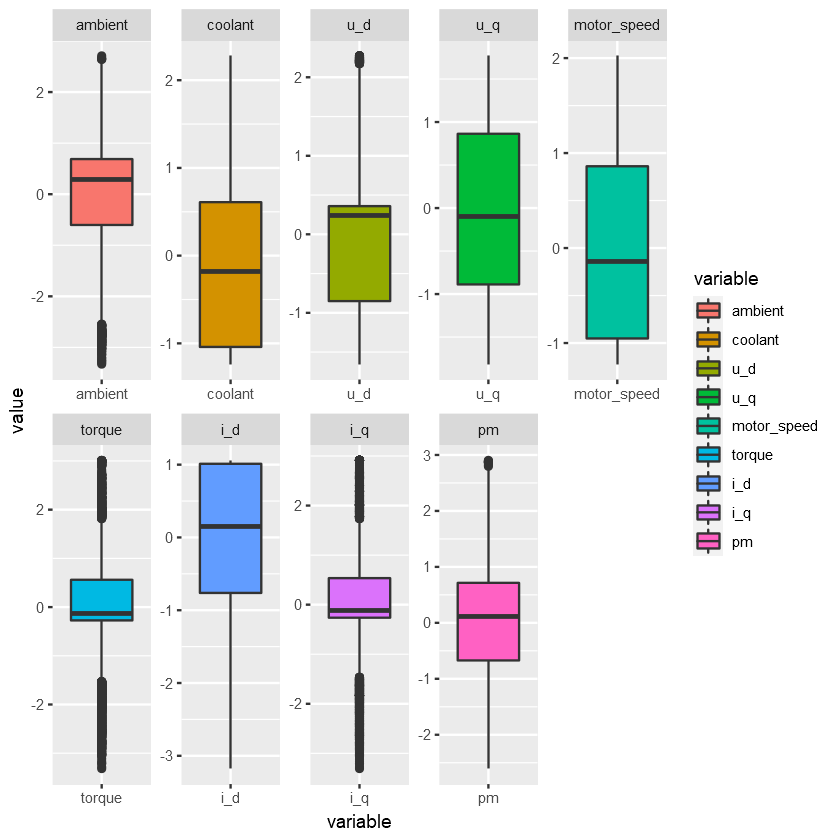

In [6]:

# Melt the data
m <- melt(train_pmsm)

# Plot the boxplot of each variable
ggplot(m,aes(x=variable,y=value))+
geom_boxplot(aes(fill = variable ))+
facet_wrap(~variable,scale ="free",nrow =2)

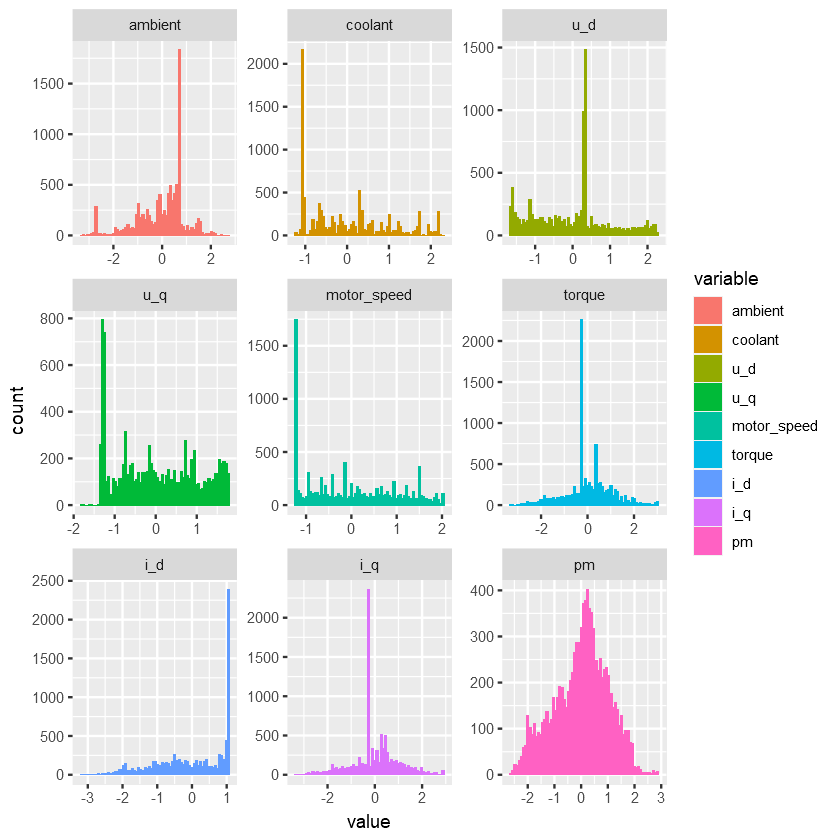

In [7]:
# Plot the histrogram of each variable
ggplot(m,aes(y=value,fill = variable))+
geom_histogram(bins =70)+
coord_flip()+ 
facet_wrap(~variable,scale ="free",nrow =3)

#### Individual Variable Analysis

- Coolant, u_q, motor speed and i_d have skewed distribution
- Ambient,u_d,torque,i_q and PM(target variable) are approximately normal distributed
- The range of each variable values varies from around -3 to 3 and some features  like motor_speed should not be negative. Therefore, we think that the data is already scaled




### 2.3 Investigate Relationship

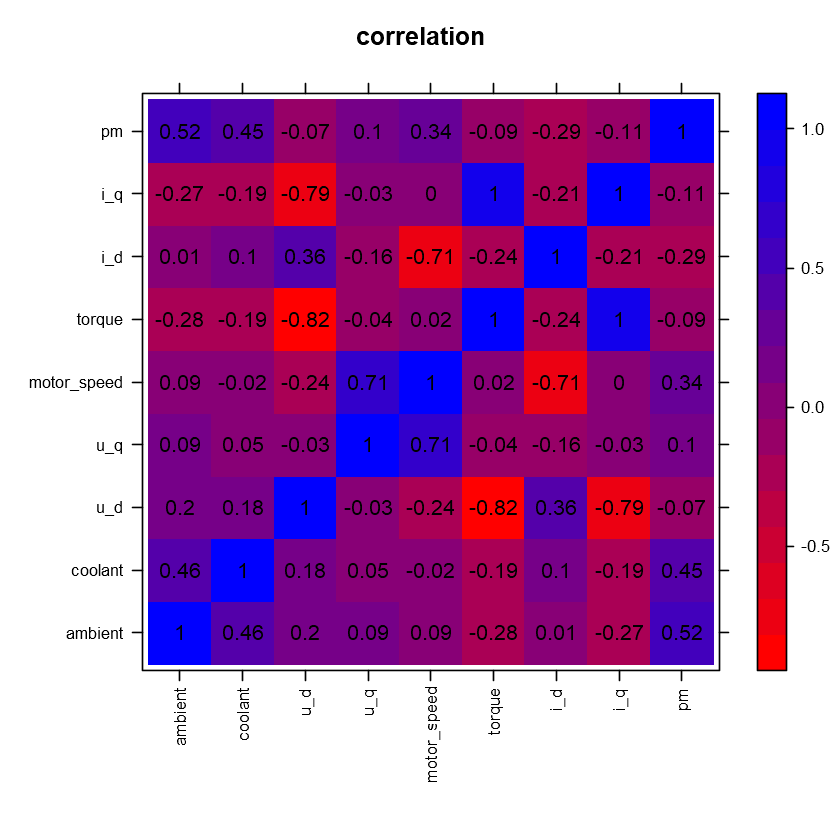

In [8]:
#Define you own panel
myPanel <- function(x, y, z, ...) {
    panel.levelplot(x,y,z,...)
    panel.text(x, y, round(z, 2))
}
#Define the color scheme
cols = colorRampPalette(c("red","blue"))

levelplot(cor(train_pmsm), col.regions = cols(100), main = "correlation", xlab = NULL, ylab = NULL, 
          scales = list(x = list(rot = 90)), panel = myPanel)

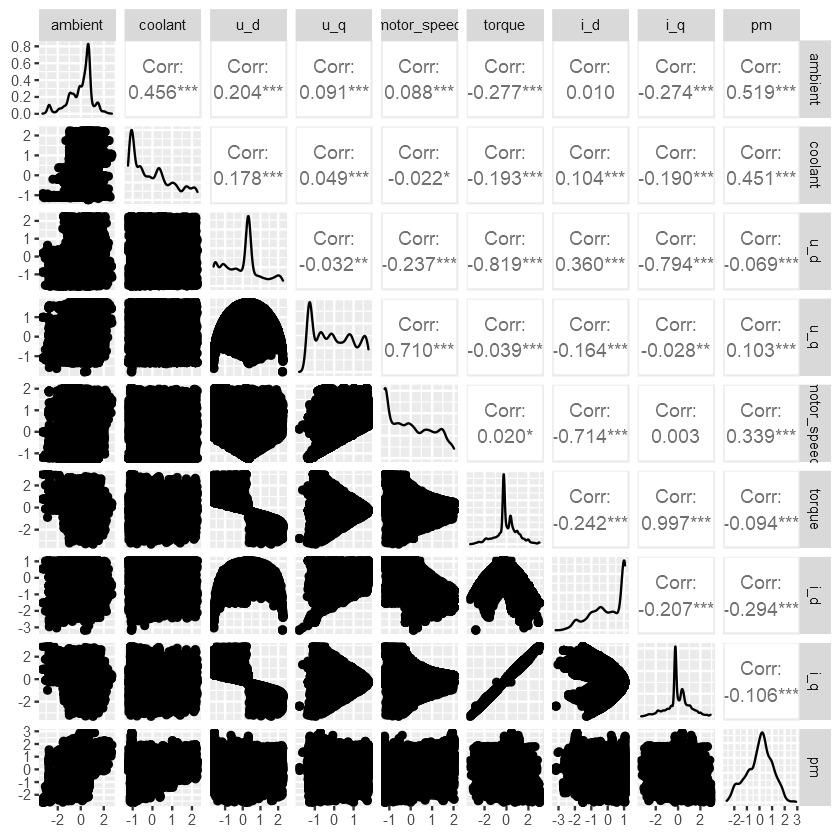

In [9]:
ggpairs(train_pmsm)

#### Relationship Analysis
- PM is moderately linearly correlated with ambient (r=0.52) and  coolant (r=0.49) and has weak/no correlation to the rest 
- There are strong positive correlation between i_q and torque (cor =  1), and, motor_speed and u_q (cor = 0.71)
- There are strong negative correlation between u_d and torque (cor =  -0.82),  u_d and i_q (cor = - 0.79), and, motor_speed and i_q (cor = -0.71)


Strong Correlation
- i_q VS torque (cor =  1)
- u_d VS torque   (cor = -0.82)
- u_d VS i_q (cor = - 0.79)
- motor_speed VS u_q (cor = 0.71)
- motor_speed VS i_d (cor = -0.71)

## 3. Methodology<a class="anchor" id="sec_4"></a>

$\textbf{Exploratory Data Analysis}$
   - Overview of the trainning dataset
   - Investigate Individual Variable Distribution
   - Investigate Relationship
   
$\textbf{Model Development}$
   - Define RMSE as a Performance Matrix
   - Basic Linear Regression Model
       - Exclude feature, which has some constraint based on domain expert or practical implementation 
       - Fit the full/base model
       - Feature Selection and Taking to Account Multicolinearity
       - Try Transforming skewed data


   - Ridge  & Lasso Regression
       -  Lasso Regression
       -  Ridge Regression 
       -  Lasso Regression with transformed feature
       -  Ridge Regression with transformed feature
       
       
   - Non-parametric Models
        -  Random Forest
        -  Extrem Gradient Boosting

## 4. Model Development <a class="anchor" id="sec_5"></a>

### 4.1 Define RMSE as a Performance Matrix

We use RMSE from predicting test data and 10-fold CV as a performance matrices 

In [10]:
# Define RMSE function as a performance matrix
RMSE <- function(predicted, target) {
    n <- length(predicted)
    MSE <-  sum((target - predicted)^2)/n
    
    RMSE <- sqrt(MSE)
    return (RMSE)
}

In [11]:
#  10-fold cross validation
train.control <- trainControl(method = "cv", number = 10)

### 4.2 Exclude feature, which has some constraint based on domain expert or practical implementation 

From our research about the task of modeling rotor temperature of permanent magnet sychronous motor (PSMS) in real-time ,  torque is a quantity, which is not reliably measurable in field application mentioning in <a href="https://www.kaggle.com/wkirgsn/electric-motor-temperature/tasks?taskId=352">here</a>. Therefore, torque is excluded for the rest of model develpoment process. Note that even we exclude torque in the model, i_q has a very high correlation with torque (cor almost equal to 1), which is a potential candidate to exclude anyway.

In [12]:
# Exclude torque feature in model development task
train_pmsm <- train_pmsm %>%
                select(-torque)

test_pmsm <- test_pmsm %>%
                select(-torque)


### 4.3 Basic Linear Regression Model

#### 4.3.1 Fit the full/base Regression Model

Try fitting all given attributes with linear regression

In [13]:
full.fit <- lm(pm ~.,train_pmsm)
summary(full.fit)


Call:
lm(formula = pm ~ ., data = train_pmsm)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8514 -0.4583 -0.0047  0.4585  3.3007 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.008469   0.007356   1.151 0.249672    
ambient      0.367943   0.008403  43.785  < 2e-16 ***
coolant      0.324418   0.008318  39.004  < 2e-16 ***
u_d         -0.150349   0.013916 -10.804  < 2e-16 ***
u_q         -0.347034   0.016018 -21.665  < 2e-16 ***
motor_speed  0.566902   0.023599  24.023  < 2e-16 ***
i_d          0.053602   0.016082   3.333 0.000862 ***
i_q         -0.062946   0.014030  -4.487 7.32e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7225 on 9644 degrees of freedom
Multiple R-squared:  0.4915,	Adjusted R-squared:  0.4911 
F-statistic:  1331 on 7 and 9644 DF,  p-value: < 2.2e-16


#### According to the full model statistics,we found that

- The F-Statistic is 1,331 with p-value < 2.2e-16 (reject null hypothesis of all feature coefficient =0) indicating that this model is meaningful


- The Adjusted R-Squared ($R^2$)  is 0.4911 meaning that the variation in Permanent Magnet surface temperature(pm) can be explained by this model by 49.11 %


- The coefficients of all predictors have P-value less than 0.05 so all features significantly contribute to the model


Plot the 4 graphs to look at residual behavior

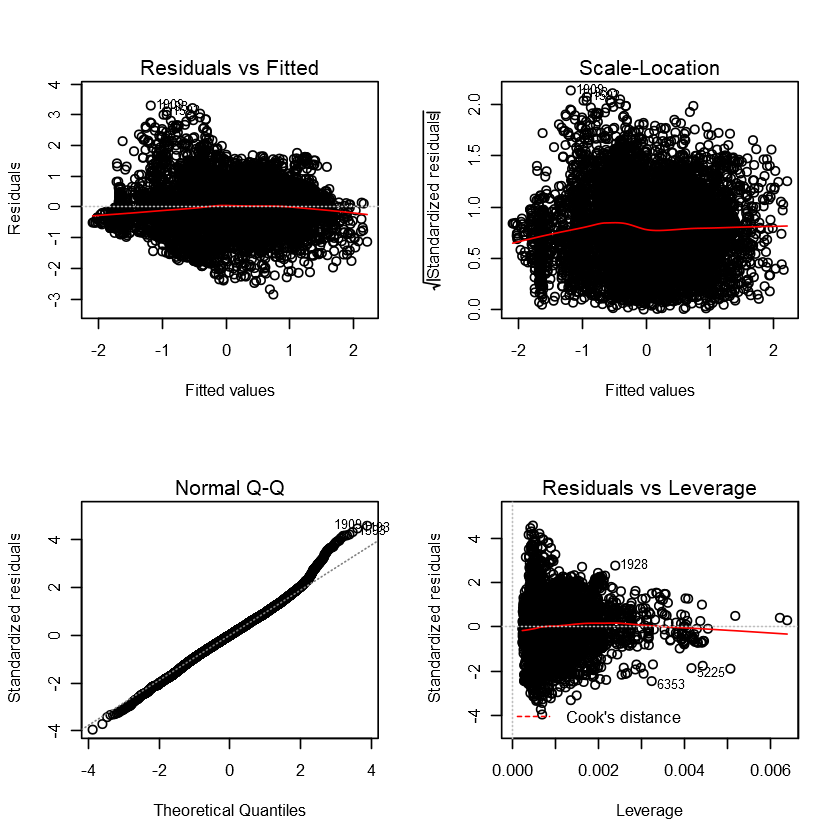

In [14]:
par(mfcol=c(2,2))
plot(full.fit)

The model plots show:

- $\textbf{Residual vs Fitted}$ - the residuals reasonably evenly distributed around 0 with no clear pattern of variance as fitted value increases. In other word, it meets homoscedasticity assumption


- $\textbf{Scale-Location }$ - The variance of the residuals is resonably constant


- $\textbf{Normal Q-Q}$ - the standardized residuals deviate slightly from Theoretical Quantiles line, showing that residuals are approximately normal distributed


- $\textbf{Residuals vs Leverage }$ - We barely see Cook's distance line, so all data points are inside Cook distance or no influential points are observed

Next, we assess model performance by using Train, Test and CV RMSE

In [15]:
# Predict on test data
pred.full.fit.test <- predict(full.fit,test_pmsm)
test.RMSE <- RMSE(pred.full.fit.test,test_pmsm$pm)
cat('The RMSE on test data of this model is ',round(test.RMSE,4),'(Base) \n')

# Predict on train data
pred.full.fit.train <- predict(full.fit,train_pmsm)
train.RMSE <- RMSE(pred.full.fit.train,train_pmsm$pm)
cat('The RMSE on train data of this model is ',round(train.RMSE,4),'(Base) \n')

# Use CV to see RMSE for CV
full.cv <- train(pm ~., data =train_pmsm  , method = "lm",
               trControl = train.control)

full.cv.RMSE <-  full.cv[['results']][['RMSE']]
cat('The RMSE on CV of this model is ',round(full.cv.RMSE,4),'(Base) \n')


The RMSE on test data of this model is  0.7098 (Base) 
The RMSE on train data of this model is  0.7222 (Base) 
The RMSE on CV of this model is  0.7227 (Base) 


#### 4.3.2 Feature Selection and Taking to Account Multicolinearity

In the full model above, it shows that all features have p-value less than 0.05 meaning that all features are relevant to pm. However, the other aspect, which is removing redundant information should be also considered, in other word, colinearity in the model should be taken into account. According to correlation matrix in EDA section, it can be seen that some predictors have linear relationship, which are the potential candidates for removing  The correlation from EDA is shown below

- u_d VS i_q (cor = - 0.79)
- motor_speed VS u_q (cor = 0.71)
- motor_speed VS i_d (cor = -0.71)



It is possible for colinearity exists between more than 2 variables, so we use variance inflation factor (VIF) to investigate multicolinearity

In [16]:
# Look at VIF to see whether multicolinearity exists
car::vif(full.fit)

ambient     coolant         u_d         u_q motor_speed         i_d 
   1.339627    1.284217    3.599084    4.707961   10.269317    4.800791 
        i_q 
   3.702347

From the VIF, motor_speed has high VIF (10.2),which indicates that multicolinearity seems to be existed in this dataset. Also, u_d,i_d and i_q are the another consideration due to moderately high correlation shown in EDA part and slightly high VIF.



First approach for feature selection in order to improve the performance and solve multicolinearity is to use exhaustive algorithm. Due to small number of features, this approach is possible and this will make sure that the result is optimal unlike stepwise approach

In [17]:
# Fit all possible models to find optimal solution

reg.fit <- regsubsets(pm~ .,data =train_pmsm)

In [18]:
# Summary of best model when different number of features is used to fit the model 
reg.summary <- summary(reg.fit)
reg.summary

Subset selection object
Call: regsubsets.formula(pm ~ ., data = train_pmsm)
7 Variables  (and intercept)
            Forced in Forced out
ambient         FALSE      FALSE
coolant         FALSE      FALSE
u_d             FALSE      FALSE
u_q             FALSE      FALSE
motor_speed     FALSE      FALSE
i_d             FALSE      FALSE
i_q             FALSE      FALSE
1 subsets of each size up to 7
Selection Algorithm: exhaustive
         ambient coolant u_d u_q motor_speed i_d i_q
1  ( 1 ) "*"     " "     " " " " " "         " " " "
2  ( 1 ) "*"     " "     " " " " " "         "*" " "
3  ( 1 ) "*"     "*"     " " " " " "         "*" " "
4  ( 1 ) "*"     "*"     " " "*" "*"         " " " "
5  ( 1 ) "*"     "*"     "*" "*" "*"         " " " "
6  ( 1 ) "*"     "*"     "*" "*" "*"         " " "*"
7  ( 1 ) "*"     "*"     "*" "*" "*"         "*" "*"

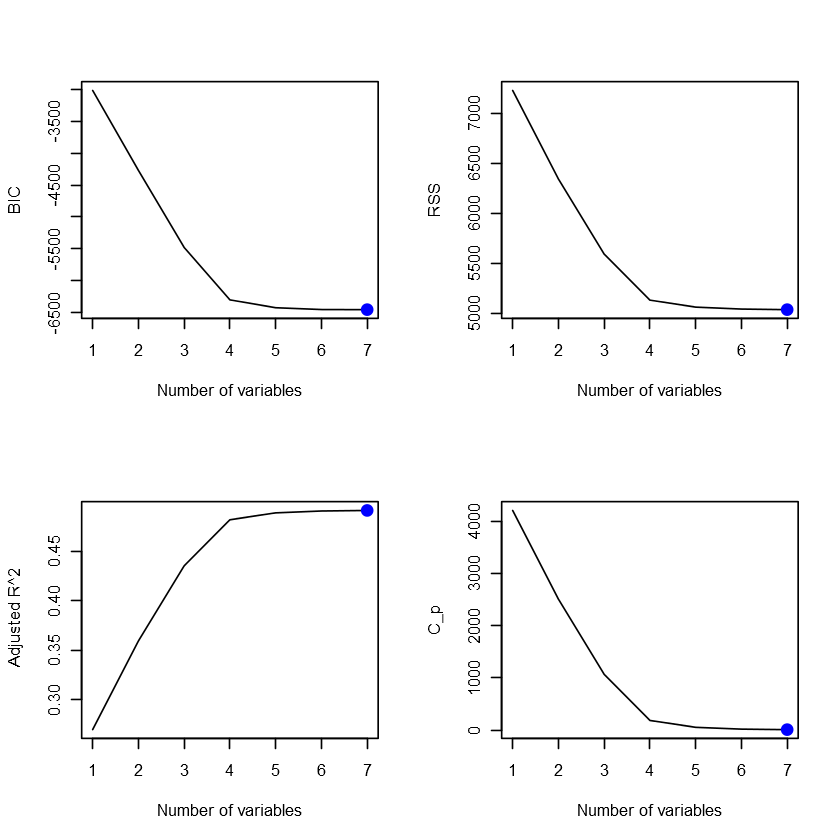

In [19]:
# Plot 4 different graphs in order to see which number of features is the most appropriate 
par(mfcol=c(2,2))

# Plot BIC
plot(reg.summary$bic, xlab = "Number of variables", ylab = "BIC", type = "l")
minbic <- which.min(reg.summary$bic)
points(minbic, reg.summary$bic[minbic], col = "blue", cex = 2, pch = 20)

# Plot Adjusted Rsquare
plot(reg.summary$adjr2, xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")
max_adjr2 <- which.max(reg.summary$adjr2)
points(max_adjr2, reg.summary$adjr2[max_adjr2 ], col = "blue", cex = 2, pch = 20)

# Plot Rsquare
plot(reg.summary$rss, xlab = "Number of variables", ylab = "RSS", type = "l")
min_rss <- which.min(reg.summary$rss)
points(min_rss, reg.summary$rss[min_rss ], col = "blue", cex = 2, pch = 20)

# Plot cp
plot(reg.summary$cp, xlab = "Number of variables", ylab = "C_p", type = "l")
mincp <- which.min(reg.summary$cp)
points(mincp, reg.summary$cp[mincp], col = "blue", cex = 2, pch = 20)

As a result, all measurements from the 4 graphs indicate that full model with 7 features is the best. However, the models after removing features that have colinearity is worth to further investigate. There are three candidates, which are motor_speed, i_d and u_q. The process to look at model performance is shown belown.

In [20]:
# Try Removing 1 feature and 2  features for different combination and show their performance

# Extract predictor name
colname <- names(train_pmsm)[-8]

# Name the features that consider to exclude
rmname <- c('motor_speed','i_d','i_q')

# Create placeholder for performance matrices
rm2_trace <- data.frame('Remove_Feautrue_1' = rep(0,length(rmname)),
                        'Remove_Feautrue_2' = rep(0,length(rmname)),
                        'AdjRSquare' = rep(0,length(rmname)),
                        'TrainRMSE'= rep(0,length(rmname)),
                        'TestRMSE' = rep(0,length(rmname)),
                        'CVRMSE' = rep(0,length(rmname)))

# for one exluding variable
for (i in 1:length(rmname)){
    
    # for another exluding variable
    for (j in 1:length(rmname)){
            set.seed(123)
        
            # 1.Record remove feature
            index <- (i-1)*length(rmname)+j
            rm2_trace[index,1] <- rmname[i]
            rm2_trace[index,2] <- rmname[j]

            cur_feature <- colname[!colname%in% rmname[i] &!colname%in% rmname[j]] 


            regressionFormula <- as.formula( paste("pm ~ ", paste(cur_feature, collapse="+")))

            # Fit the model with one removing feature
            man.sel.fit1 <- lm(regressionFormula,train_pmsm)

            # 2.Record adjusted R square
            rm2_trace[index,3] <- summary(man.sel.fit1)$adj.r.squared


            # Predict on train data
            pred.man.sel.fit1.train <- predict(man.sel.fit1,train_pmsm)
            train.RMSE <- RMSE(pred.man.sel.fit1.train,train_pmsm$pm)

            # 3.Record train RMSE
            rm2_trace[index,4] <- train.RMSE


            # Predict on test data
            pred.man.sel.fit1.test <- predict(man.sel.fit1,test_pmsm)
            test.RMSE <- RMSE(pred.man.sel.fit1.test,test_pmsm$pm)

            # 4.Record train RMSE
            rm2_trace[index,5] <- test.RMSE

            model <- train(regressionFormula, data =train_pmsm  , method = "lm",
                        trControl = train.control)

            rm2_trace[index,6] <- model[['results']][['RMSE']]
        }
}

# Replace - to the same varaible for better visualisation
for (i in(1:nrow(rm2_trace))){
    
    if(rm2_trace[i,1]==rm2_trace[i,2]){rm2_trace[i,2] = '-'}
    
}

In [21]:
# Show the removing feature models with their performance ranking by test RMSE
print("The model performance when removing 1 or 2 features that have high colinearity")
rm2_trace %>%
    arrange(TestRMSE,CVRMSE) %>%
    distinct(AdjRSquare,TrainRMSE,TestRMSE,CVRMSE, .keep_all = TRUE)


[1] "The model performance when removing 1 or 2 features that have high colinearity"


Remove_Feautrue_1,Remove_Feautrue_2,AdjRSquare,TrainRMSE,TestRMSE,CVRMSE
motor_speed,i_q,0.4433837,0.7553770,0.6877578,0.7556020
motor_speed,-,0.4606921,0.7435011,0.6906595,0.7437365
i_d,-,0.4905559,0.7226226,0.7060391,0.7228882
i_d,i_q,0.4886496,0.7240109,0.7060466,0.7242297
i_q,-,0.4900800,0.7229601,0.7115782,0.7232735
i_d,motor_speed,0.3970370,0.7861965,0.7209927,0.7865240
motor_speed,i_d,0.3970370,0.7861965,0.7209927,0.7865240


Note that first thing that can be observed from the above table is that test RMSE of all models are higher than train RMSE. One possible reason is that testing dataset contains easier example (reference from <a href="https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error">here</a>  and <a href="https://www.researchgate.net/post/When_can_Validation_Accuracy_be_greater_than_Training_Accuracy_for_Deep_Learning_Models">here</a> ) or the dataset is not large enough. In other word, the test data might not represent the real data distribution, which makes sense due to sampling approach that use some profile_id a test data (this should sample random profile id instead) 

Therefore, in this case using test RMSE alone might not be appropriate to evaluate the best performance model. RMSE of 10 fold cross validation and train data should be considered when selecting the model

From the table above, this displays model performance when removing some features, which have some colinearity. If models remove one feature, the Remove_Feautrue_2 column is '-', otherwise it is the performance of removing two features. The table is sorted ascendingly by test RMSE. 

For our analysis, although excluding motor_speed & i_q or motor_speed  gives us lower test RMSE than the base model, CV RMSE and train RMSE are higher. Using these excluding strategies might not appropriate because this is an evidence that this model cannot generalise well. However, excluding i_d only yields a better test RMSE than the base model, but not significantly worsen Train and CV RMSE. 


In the exhaustive approach, it suggest us to have a full model with 7 features without removing anything. The full modeul has  adjRsquare = 0.4915, test RMSE = 0.7098, Train RMSE = 0.7222 and CV RMSE = 0.7224. In the model that exclude i_d, the adjRsquare and train RMSE of this model are 0.4906 and 0.7226, which slightly decreases in adjusted r square and slightly increase in train error from the full model. However, the test RMSE is improved to 0.7060. Also, removing i_d brings VIF of every variables down which reduce multicolinearity problem (this is shown in table below) so removing i_d should be considered for developing the model.



In [22]:
# fit the model that exludes i_d
rm.fit <- lm(pm ~.-i_d,train_pmsm)

# Show VIF result
car::vif(rm.fit)
summary(rm.fit)

ambient     coolant         u_d         u_q motor_speed         i_q 
   1.339577    1.283456    3.462275    2.215254    2.587647    3.223143


Call:
lm(formula = pm ~ . - i_d, data = train_pmsm)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8507 -0.4586 -0.0024  0.4594  3.3167 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.008172   0.007359   1.110    0.267    
ambient      0.367770   0.008408  43.742  < 2e-16 ***
coolant      0.325093   0.008319  39.076  < 2e-16 ***
u_d         -0.159392   0.013656 -11.672  < 2e-16 ***
u_q         -0.308186   0.010993 -28.034  < 2e-16 ***
motor_speed  0.498875   0.011852  42.092  < 2e-16 ***
i_q         -0.079770   0.013097  -6.091 1.17e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7229 on 9645 degrees of freedom
Multiple R-squared:  0.4909,	Adjusted R-squared:  0.4906 
F-statistic:  1550 on 6 and 9645 DF,  p-value: < 2.2e-16


After redundant information is excluded, the model is more interpretable. In the model above, we can make an inference that the features (after scaling) that contribute the most to this model are motor_speed (coef :0.4989), ambient(coef : 0.3678) and coolant(coef : 0.3251)



#### 4.3.3 Try Transforming skewed data

From the EDA part, we found that coolant, u_q, motor_speed and i_d have skewed distribution so those are potential candidates for transformation. As data in features already scaled containing negative value, log and square root transformation might not be the best choice. Therefore, we try to transform using cube root, polynomial  with degree 2 and polynomail with degree 3. Then, we plot those features with their transformation below 

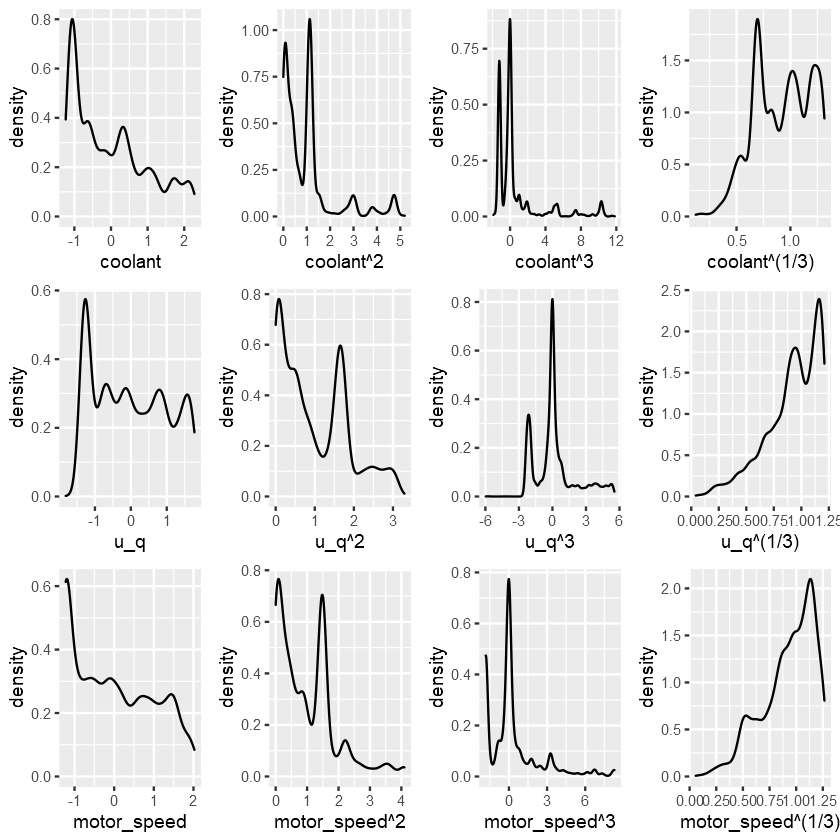

In [23]:
# Plot graphs for all transformation candidates and their 3 transformation

plot1 <- ggplot(data = train_pmsm, aes(x=coolant)) +
    geom_density()

plot2 <-ggplot(data = train_pmsm, aes(x=coolant^2)) +
    geom_density()


plot3 <-ggplot(data = train_pmsm, aes(x=coolant^3)) +
    geom_density()

plot4 <-ggplot(data = train_pmsm, aes(x=coolant^(1/3))) +
    geom_density()


plot5 <- ggplot(data = train_pmsm, aes(x=u_q)) +
    geom_density()

plot6 <-ggplot(data = train_pmsm, aes(x=u_q^2)) +
    geom_density()


plot7 <-ggplot(data = train_pmsm, aes(x=u_q^3)) +
    geom_density()

plot8 <-ggplot(data = train_pmsm, aes(x=u_q^(1/3))) +
    geom_density()

plot9 <- ggplot(data = train_pmsm, aes(x=motor_speed)) +
    geom_density()

plot10 <-ggplot(data = train_pmsm, aes(x=motor_speed^2)) +
    geom_density()


plot11 <-ggplot(data = train_pmsm, aes(x=motor_speed^3)) +
    geom_density()

plot12 <-ggplot(data = train_pmsm, aes(x=motor_speed^(1/3))) +
    geom_density()



grid.arrange(plot1, plot2,plot3,plot4,
             plot5, plot6,plot7,plot8,
             plot9, plot10,plot11,plot12,
             ncol=4,nrow =3)


One feature, which is u_q  looks more normally distributed when using cube transformation, while the rest is still unclear improvement from transformation. So we try to transform u_q and fit in the linear model.  

In [24]:
trans.fit <- update(rm.fit,pm ~.-u_q+poly(u_q,3),train_pmsm)
summary(trans.fit)


Call:
lm(formula = pm ~ ambient + coolant + u_d + motor_speed + i_q + 
    poly(u_q, 3), data = train_pmsm)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8730 -0.4545  0.0012  0.4572  3.2768 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.005735   0.007356   0.780  0.43561    
ambient         0.369930   0.008424  43.915  < 2e-16 ***
coolant         0.325610   0.008323  39.122  < 2e-16 ***
u_d            -0.165138   0.013767 -11.996  < 2e-16 ***
motor_speed     0.488651   0.012166  40.165  < 2e-16 ***
i_q            -0.087430   0.013254  -6.596 4.43e-11 ***
poly(u_q, 3)1 -29.510899   1.089749 -27.080  < 2e-16 ***
poly(u_q, 3)2  -1.580421   0.743222  -2.126  0.03349 *  
poly(u_q, 3)3   2.286801   0.738177   3.098  0.00195 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7224 on 9643 degrees of freedom
Multiple R-squared:  0.4916,	Adjusted R-squared:  0.4912 
F-statistic:  1166 on 8 and

In [25]:
# Using Anova to compare the previous model that adding and transforming to polynomial degree makes different or not
anova(rm.fit,trans.fit)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
9645,5040.114,NA,NA,NA,NA
9643,5032.986,2,7.128193,6.828666,0.001087542


The p-value of anova test above indicates that 2 models are significantly different at 95% confidence interval due to low value of p-value. In other word, adding polynomial degree 3 on u_q makes the model performance different from the previous one.

In [26]:
# Predict on test data

pred.trans.test <- predict(trans.fit,test_pmsm)
test.RMSE <- RMSE(pred.trans.test,test_pmsm$pm)
cat('The RMSE on test data of this model is ',round(test.RMSE,4),'(transformation) \n')

# Predict on train data
pred.trans.train <- predict(trans.fit,train_pmsm)
train.RMSE <- RMSE(pred.trans.train,train_pmsm$pm)
cat('The RMSE on train data of this model is ',round(train.RMSE,4),'(transformation) \n')

# Use CV to see RMSE for CV
set.seed(123)
trans.cv <- train(pm ~.-u_q+poly(u_q,3), data =train_pmsm  , method = "lm",
               trControl = train.control)
trans.cv.RMSE <-  trans.cv[['results']][['RMSE']]
cat('The RMSE on CV of this model is ',round(full.cv.RMSE,4),'(transformation) \n')


The RMSE on test data of this model is  0.6993 (transformation) 
The RMSE on train data of this model is  0.7221 (transformation) 
The RMSE on CV of this model is  0.7227 (transformation) 


The test, train and CV rmse slightly improves after transforming the data 

In conclusion, the model that combine feature selection and transformation (trans.fit) gives the best result for fitting linear regression without worsen train and CV RMSE compare to the base model. The second best is the model that remove i_d (rm.fit). However trans.fit has to consider the trade off about model size and interpretation ability, which will be further discusse in section 5 ( Results and discussion) 

### 4.4  Ridge and Lasso Regression

In this part, we try to add some L1 and L2 regularisation term and fit ridge and lasso regression. The models fit every feature with and without transformation (polynomial with degree 3 transformation in u_q).

#### 4.4.1  Lasso Regression 

The first part, we fit lasso regression to all features without transformed feature

In [27]:
# Transform data to matrix before processing CV for lasso and Ridge
trainmat <- model.matrix(pm ~ ., data = train_pmsm)
testmat  <- model.matrix(pm ~ ., data = test_pmsm)

trainmat <- trainmat[,-1]
testmat  <- testmat[,-1]


In [28]:
# Use CV to find the best lambda for lasso
set.seed(123)
cv.lasso <- cv.glmnet(trainmat, train_pmsm$pm, alpha = 1)

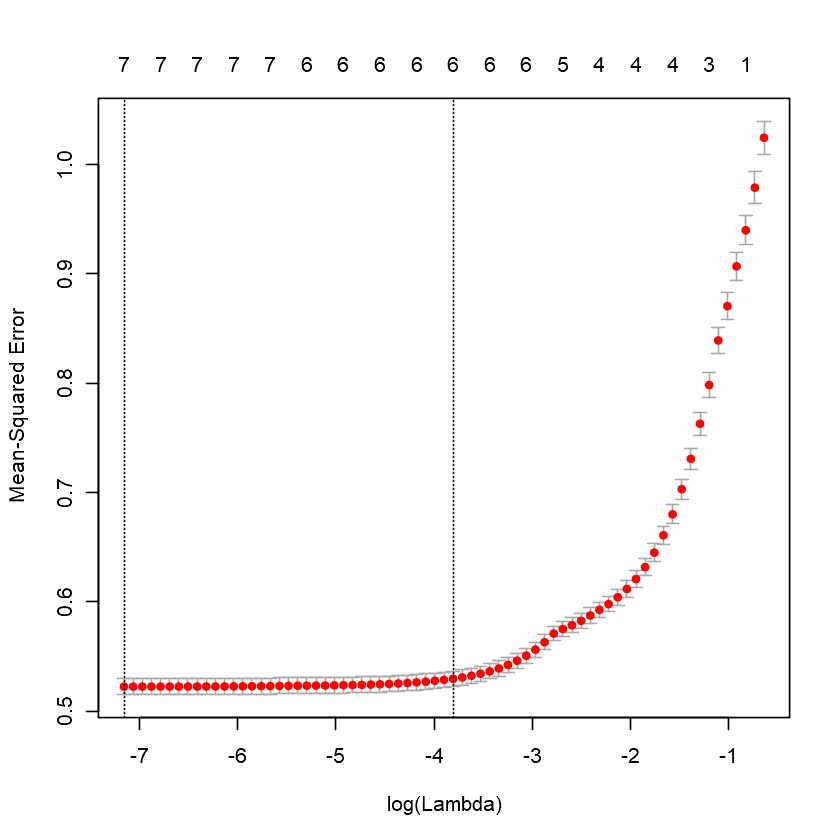

In [29]:
# Plot Lambda VS MSE in Lasso
plot(cv.lasso)

In [30]:
# Select the best lambda, which gives the lowest MSE in CV in Lasso
lasso.bestlam <- cv.lasso$lambda.min

# Find RMSE for the best lambda 
lasso_cv_rmse <-  sqrt(cv.lasso$cvm[cv.lasso$lambda==cv.lasso$lambda.min])
cat('The best lambda is ',lasso.bestlam)
cat(', which yields RMSE = ',lasso_cv_rmse)

The best lambda is  0.000780961, which yields RMSE =  0.722759

In [31]:
# Fit the lasso regression
fit.lasso <- glmnet(trainmat, train_pmsm$pm, alpha = 1)

In [32]:
# Look at lasso coefficeint
predict(fit.lasso, s = lasso.bestlam, type = "coefficients")[1:8,]

(Intercept)      ambient      coolant          u_d          u_q  motor_speed 
 0.008407516  0.367666124  0.323758128 -0.149420603 -0.336617935  0.551250626 
         i_d          i_q 
 0.042983594 -0.063494031

In [33]:
# Predict on test data
pred.lasso.test <- predict(fit.lasso, s = lasso.bestlam, newx = testmat)
lasso.test.RMSE <- RMSE(pred.lasso.test,test_pmsm$pm)

# Print RMSE for test data in Lasso
cat('The RMSE on test data of this model is ',round(lasso.test.RMSE,4),'(Lasso) \n')

# Predict on train data
pred.lasso.train <- predict(fit.lasso, s = lasso.bestlam, newx = trainmat)
lasso.train.RMSE <- RMSE(pred.lasso.train,train_pmsm$pm)

# Print RMSE for train data in Lasso
cat('The RMSE on train data of this model is ',round(lasso.train.RMSE,4),'(Lasso) \n')

# Print RMSE for CV in Lasso
cat('The RMSE on CV of this model is ',round(lasso_cv_rmse,4),'(Lasso) \n')

The RMSE on test data of this model is  0.7085 (Lasso) 
The RMSE on train data of this model is  0.7222 (Lasso) 
The RMSE on CV of this model is  0.7228 (Lasso) 


#### 4.4.2  Ridge Regression 

In [34]:
# Use CV to find the best lambda for Ridge
set.seed(123)
cv.ridge<- cv.glmnet(trainmat, train_pmsm$pm, alpha = 0)

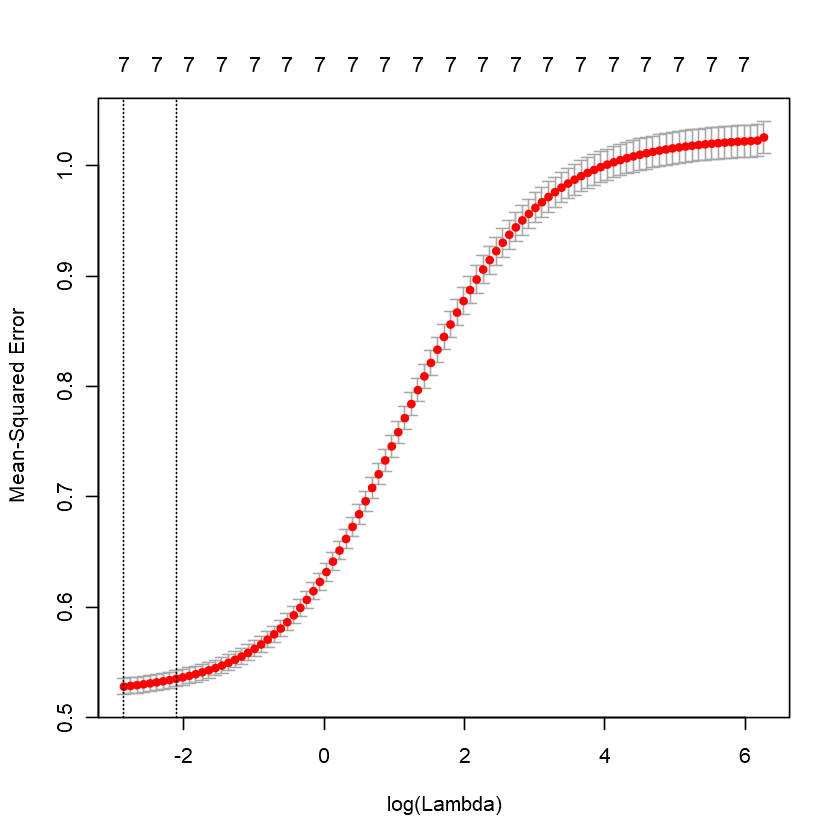

In [35]:
# Plot Lambda VS MSE in Ridge
plot(cv.ridge)

In [36]:
# Select the best lambda, which gives the lowest MSE in CV in Ridge
ridge.bestlam <- cv.ridge$lambda.min

# Find RMSE for the best lambda 
ridge_cv_rmse <-  sqrt(cv.ridge$cvm[cv.ridge$lambda==cv.ridge$lambda.min])
cat('The best lambda is ',ridge.bestlam)
cat(', which yields RMSE = ',ridge_cv_rmse)

The best lambda is  0.05771866, which yields RMSE =  0.7266419

In [37]:
# Fit the ridge regression
fit.ridge <- glmnet(trainmat, train_pmsm$pm, alpha = 0)

In [38]:
# Look at ridge coefficeint
predict(fit.ridge, s = ridge.bestlam, type = "coefficients")[1:8,]

(Intercept)     ambient     coolant         u_d         u_q motor_speed 
 0.00792288  0.35459317  0.31033613 -0.16139963 -0.20256965  0.35231204 
        i_d         i_q 
-0.07249125 -0.09400965

In [39]:
# Predict on test data
pred.ridge.test <- predict(fit.ridge, s = ridge.bestlam, newx = testmat)
test.RMSE <- RMSE(pred.ridge.test,test_pmsm$pm)
# Print RMSE for test data in Ridge
cat('The RMSE on test data of this model is ',round(test.RMSE,4),'(Ridge) \n')

# Predict on train data
pred.ridge.train <- predict(fit.ridge, s = ridge.bestlam, newx = trainmat)
train.RMSE <- RMSE(pred.ridge.train,train_pmsm$pm)
# Print RMSE for train data in Ridge
cat('The RMSE on train data of this model is ',round(train.RMSE,4),'(Ridge) \n')

# Print RMSE for CV in ridge
cat('The RMSE on CV of this model is ',round(ridge_cv_rmse,4),'(Ridge) \n')

The RMSE on test data of this model is  0.6956 (Ridge) 
The RMSE on train data of this model is  0.7262 (Ridge) 
The RMSE on CV of this model is  0.7266 (Ridge) 


#### 4.4.3  Lasso Regression with transformed feature

In [40]:
# Transform to matrix before processing CV for lasso and Ridge with transformed feature
trainmat <- model.matrix(pm ~ .-u_q+poly(u_q,3), data = train_pmsm)
testmat  <- model.matrix(pm ~ .-u_q+poly(u_q,3), data = test_pmsm)

trainmat <- trainmat[,-1]
testmat  <- testmat[,-1]


In [41]:
# Use CV to find the best lambda for lasso with transformed feature
set.seed(123)
cv.lasso <- cv.glmnet(trainmat, train_pmsm$pm, alpha = 1)

In [42]:
# Select the best lambda, which gives the lowest MSE in CV in Lasso
lasso.bestlam <- cv.lasso$lambda.min

# Find RMSE for the best lambda 
lasso_cv_rmse <-  sqrt(cv.lasso$cvm[cv.lasso$lambda==cv.lasso$lambda.min])
cat('The best lambda is ',lasso.bestlam)
cat(', which yields RMSE = ',lasso_cv_rmse)

The best lambda is  0.0007115826, which yields RMSE =  0.7218058

In [43]:
# Fit the lasso regression with transformed the data
fit.lasso <- glmnet(trainmat, train_pmsm$pm, alpha = 1)

In [44]:
# Look at lasso with transformed the data coefficeint
predict(fit.lasso, s = lasso.bestlam, type = "coefficients")[1:10,]

(Intercept)       ambient       coolant           u_d   motor_speed 
  0.005784755   0.371058194   0.324322673  -0.151701215   0.581224026 
          i_d           i_q poly(u_q, 3)1 poly(u_q, 3)2 poly(u_q, 3)3 
  0.078499632  -0.063808948 -34.526252262  -2.653601445   3.162786901

In [45]:
# Predict on test data
pred.lasso.test <- predict(fit.lasso, s = lasso.bestlam, newx = testmat)
lasso.test.RMSE <- RMSE(pred.lasso.test,test_pmsm$pm)

# Print RMSE for test data in Lasso with transformed feature
cat('The RMSE on test data of this model is ',round(lasso.test.RMSE,4),'(Lasso with transformed feature) \n')

# Predict on train data
pred.lasso.train <- predict(fit.lasso, s = lasso.bestlam, newx = trainmat)
lasso.train.RMSE <- RMSE(pred.lasso.train,train_pmsm$pm)

# Print RMSE for train data in Lasso with transformed feature
cat('The RMSE on train data of this model is ',round(lasso.train.RMSE,4),'(Lasso with transformed feature) \n')

# Print RMSE for CV in Lasso with transformed feature
cat('The RMSE on CV of this model is ',round(lasso_cv_rmse,4),'(Lasso with transformed feature) \n')

The RMSE on test data of this model is  0.6528 (Lasso with transformed feature) 
The RMSE on train data of this model is  0.7211 (Lasso with transformed feature) 
The RMSE on CV of this model is  0.7218 (Lasso with transformed feature) 


#### 4.4.4  Ridge Regression with transformed feature

In [46]:
# Use CV to find the best lambda for Ridge with transformed feature
set.seed(123)
cv.ridge<- cv.glmnet(trainmat, train_pmsm$pm, alpha = 0)

In [47]:
# Select the best lambda, which gives the lowest MSE in CV in Ridge with transformed data
ridge.bestlam <- cv.ridge$lambda.min

# Find RMSE for the best lambda 
ridge_cv_rmse <-  sqrt(cv.ridge$cvm[cv.ridge$lambda==cv.ridge$lambda.min])
cat('The best lambda is ',ridge.bestlam)
cat(', which yields RMSE = ',ridge_cv_rmse)

The best lambda is  0.05771866, which yields RMSE =  0.7262442

In [48]:
# Fit the ridge regression with transformed feature
fit.ridge <- glmnet(trainmat, train_pmsm$pm, alpha = 0)

In [49]:
# Look at ridge with transformed feature coefficeint
predict(fit.ridge, s = ridge.bestlam, type = "coefficients")[1:10,]

(Intercept)       ambient       coolant           u_d   motor_speed 
  0.006332383   0.356171638   0.310462257  -0.163809426   0.358197208 
          i_d           i_q poly(u_q, 3)1 poly(u_q, 3)2 poly(u_q, 3)3 
 -0.061294237  -0.095945567 -20.081799132  -1.009299959   1.802829896

In [50]:
# Predict on test data
pred.ridge.test <- predict(fit.ridge, s = ridge.bestlam, newx = testmat)
test.RMSE <- RMSE(pred.ridge.test,test_pmsm$pm)
# Print RMSE for test data in Ridge
cat('The RMSE on test data of this model is ',round(test.RMSE,4),'(Ridge with transformed feature) \n')

# Predict on train data
pred.ridge.train <- predict(fit.ridge, s = ridge.bestlam, newx = trainmat)
train.RMSE <- RMSE(pred.ridge.train,train_pmsm$pm)
# Print RMSE for train data in Ridge
cat('The RMSE on train data of this model is ',round(train.RMSE,4),'(Ridge with transformed feature) \n')

# Print RMSE for CV in ridge
cat('The RMSE on CV of this model is ',round(ridge_cv_rmse,4),'(Ridge with transformed feature) \n')

The RMSE on test data of this model is  0.6563 (Ridge with transformed feature) 
The RMSE on train data of this model is  0.7256 (Ridge with transformed feature) 
The RMSE on CV of this model is  0.7262 (Ridge with transformed feature) 


### 4.5  Non-Parametric Model

Next, we try some non-parametric models for this task, which are random forest and extreme boosting.

#### 4.5.1 Random Forest 

In hyperparamter tuning part, we use train function in caret package, which allows us to find good parameter that has as low CV RMSE as possible. In this case, we use "rf' method with 1 tuning parameter (mtry). We comment this process because it takes quite long but the the best mtry in this case is mtry =6

In [51]:
# tuneGrid <- expand.grid(mtry = c(1: 7))

# Fit Random Forest Model with hyperparameter tuning
# train_control <- caret::trainControl(
#   method = "cv",
#   verboseIter = FALSE,
#   number = 5,
#   allowParallel = TRUE 
# )

# rf_tune <- caret::train(
#   pm ~ .,
#   data = train_pmsm,
#   trControl = train_control,
#   tuneGrid = tuneGrid,
#   method = "rf",
#   objective = "reg:squarederror",
# )

Then, we fit random forsest with mtry = 6

In [52]:
# When doing hyperparameter tuning using CV to minimis RMSE CV mtry =6 give the best result
set.seed(123)
tuneGrid <- expand.grid(mtry = 6)

train_control <- caret::trainControl(
  method = "cv",
  verboseIter = FALSE,
  number = 5,
  allowParallel = TRUE 
)

# Fit Random Forest Model with hyperparameter tuning
rf_final <- caret::train(
  pm ~ .,
  data = train_pmsm,
  trControl = train_control,
  tuneGrid = tuneGrid,
  method = "rf",
  objective = "reg:squarederror",
)



In [53]:
# Show the random forest performance result from 5-fold cross validation 
rf_final

Random Forest 

9652 samples
   7 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 7722, 7721, 7722, 7722, 7721 
Resampling results:

  RMSE       Rsquared   MAE      
  0.3666173  0.8701511  0.2365589

Tuning parameter 'mtry' was held constant at a value of 6

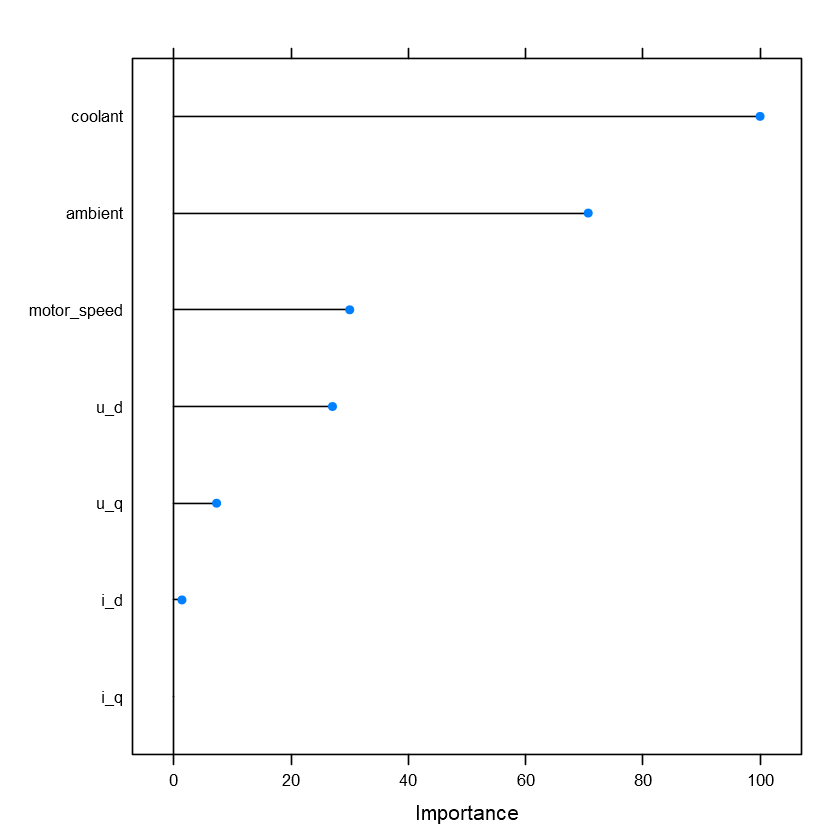

In [54]:
# PLot feature importance in random forest model 
plot(varImp(rf_final))

The graph above shows the feature importance. This can be interpreted that coolent, ambient and motor speed contribute the most in this Random forst model

In [55]:
# Predict on test data
pred.rf.test <- predict(rf_final,test_pmsm)
test.RMSE <- RMSE(pred.rf.test,test_pmsm$pm)

# Print RMSE for test data in Random Forest
cat('The RMSE on test data of this model is ',round(test.RMSE,4),'(Random Forest) \n')


# Predict on train data
pred.rf.train <- predict(rf_final,train_pmsm)
train.RMSE <- RMSE(pred.rf.train,train_pmsm$pm)

# Print RMSE for test data in Random Forest
cat('The RMSE on train data of this model is ',round(train.RMSE,4),'(Random Fores) \n')

# Print RMSE for CV in ridge
cv.RMESE <- rf_final$results$RMSE
cat('The RMSE on CV of this model is ',round(cv.RMESE,4),'(Random Forest) \n')


The RMSE on test data of this model is  0.8227 (Random Forest) 
The RMSE on train data of this model is  0.1426 (Random Fores) 
The RMSE on CV of this model is  0.3666 (Random Forest) 


#### 4.5.2 Extreme Gradient Boositing (with default parameter setting)

In hyperparamter tuning part, we use train function in caret package, which allows us to find good parameter that has as low CV RMSE as possible. In this case, we use "xgbTree" method with 7 tuning parameters (use 5 fold CV with grid search to select hyperparameters). Then we fit the xgboost with parameters listed  final_grid below. 

In [56]:
# Fit xgboost model

set.seed(123)
options(warn = -1)

# List all paramter after hyperparameter tuning
final_grid <- expand.grid(
  nrounds = 5000,
  eta = 0.025,
  max_depth = 6,
  gamma = 0,
  colsample_bytree = 1,
  min_child_weight = 1,
  subsample = 0.75
)

# Set train control to look at CV performance
train_control <- caret::trainControl(
  method = "cv",
  number = 5,
  verboseIter = FALSE,
  allowParallel = TRUE 
)


xgb_final <- caret::train(
  x = as.matrix(train_pmsm[,names(train_pmsm)!="pm"]),
  y = train_pmsm$pm,
  trControl = train_control,
  tuneGrid = final_grid,
  method = "xgbTree",
  verbose = TRUE,
  objective = "reg:squarederror"
)


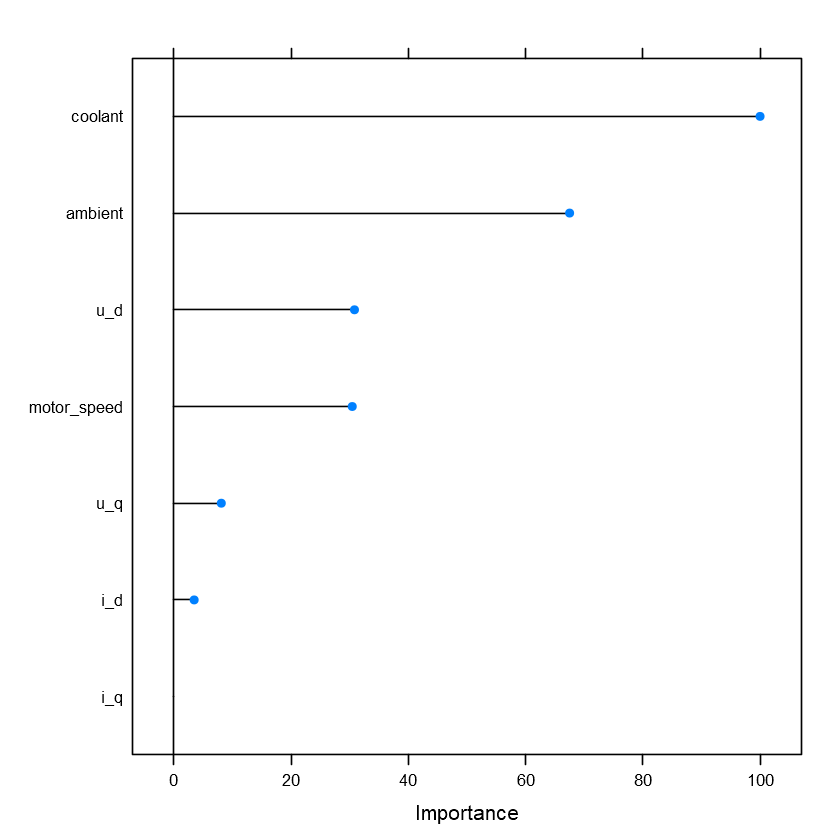

In [57]:
# PLot feature importance for xgboost model 
plot(varImp(xgb_final))

The graph above shows the feature importance. This can be interpreted that coolent, ambient and u_d contribute the most in this xgboost model

In [58]:
# Predict on test data
pred.xgb.test <- predict(xgb_final,test_pmsm)
test.RMSE <- RMSE(pred.xgb.test,test_pmsm$pm)

# Print RMSE for test data in Random Forest
cat('The RMSE on test data of this model is ',round(test.RMSE,4),'(xgboost) \n')


# Predict on train data
pred.xgb.train <- predict(xgb_final,train_pmsm)
train.RMSE <- RMSE(pred.xgb.train,train_pmsm$pm)

# Print RMSE for test data in Random Forest
cat('The RMSE on train data of this model is ',round(train.RMSE,4),'(xgboost) \n')

# Print RMSE for CV in ridge
cv.RMESE <- xgb_final$results$RMSE
cat('The RMSE on CV of this model is ',round(cv.RMESE,4),'(xgboost) \n')


The RMSE on test data of this model is  0.8291 (xgboost) 
The RMSE on train data of this model is  0.0594 (xgboost) 
The RMSE on CV of this model is  0.3599 (xgboost) 


As a result, both tree-based models provide a better results in train and CV RMSE. However, test RMSE is underperformed. So we will not use those models as a final models.

## 5. Results and discussion <a class="anchor" id="sec_6"></a>

So far, we have developed several models listed in table below starting from full linear model to more complicated non parametric model. Test, Train and CV RMSE are reported as performance matrices for model selelection. As a result, Lasso Regression with feature transformation gives us the lowest Test RMSE with lowest Train and CV RMSE if not considering tree-based model (Random Forest & xgboost).Both random forest and xgboost with hyperparameter tuning that try to minimise CV RMSE have very low test and CV RMSE. However, their performance on test RMSE are not good. In conclusion, the final model for rotor temperature of a permanent magnet sycgronous motor in real time is Lasso Regression with feature transformation. Even this model has the largest size, the performance is significantly better than other models and size of the model is only 9, which is assumed to be acceptable.

| Model      	                                                 | Test RMSE	| Train RMSE | CV RMSE  | Size | 
|:-:    	                                                     |:-:	        |:-:	    |:-:	    |:-:   |
| Full Linear Model                                              | 0.7098       | 0.7222    | 0.7223 	|  7   |
| LM with feature selection(-i_d)                                | 0.7060       | 0.7226    | 0.7229    |  6   |
| LM with feature selection(-i_d)  and  feature transformation   | 0.7003       | 0.7211    | 0.7233 	|  8   |
| Lasso Regression                                               | 0.7085       | 0.7222    | 0.7228    |  7   |
| Ridge Regression                                               | 0.6956       | 0.7262    | 0.7266    |  7   |
| Lasso Regression with feature transformation                   | 0.6528       | 0.7211    | 0.7218    |  9   |
| Ridge Regression with feature transformation                   | 0.6563       | 0.7256    | 0.7262 	|  9   |
| Random Forest                                                  | 0.8227       | 0.1426    | 0.3666	|  7   |
| Extreme Gradient Boosting                                      | 0.8291       | 0.0594    | 0.3599 	|  7    |

## 6. Conclusion<a class="anchor" id="sec_7"></a>

In conclusion, there are two main tasks that will be discussed and summarised based on the findings on part 2: Exploratory Data Analysis and part 4 Model development, which are :

$\textbf{1. Prediction Task} $ 


- First of all, we split the test data by using profile_id 72 and 81 and the rest as a train data
- In model development process, torque is excluded due to limitation in field application (unreliably measurable)
- Performance metrices for prediction in this task are mainly Root Mean Square Error (RMSE) of test data along with train RMSE and average RMSE from 10 fold cross validation on train data (CV RMSE) 
- Without considering tree-based model, which has high test RMSE, Lasso Regression with polynomial degree 3 transformation on u_q has the least test RMSE, train RMSE and CV RMSE.
- Therefore,Lasso Regression with feature transformation is chosen to be the final model


$\textbf{2.Inference Task}$ (Identify subset of attribute that have significant impact on the prediction of the burned area)
    
- In EDA part, the correlation matrix is shown and  the variables that have moderate linear relationship with the target vairable, rotor temperator (PM) are :
            - Ambient temperature (ambient) with positive correlation at 0.52
            - Coolant temperature (coolant) with positive correlation at 0.45

    For the rest, they have correlation magnitude less than 0.3, so correlation of other variables are pretty weak with rotor temperature. 
      
      
- In the part 4.3.1 Fit the full/base Regression Model, when every variable (exclude torque, which we exclude before thispart) is fitted to the linear model and it turns out that they all have p-value less than 0.05. In other word, all features significantly have impact on the model or on rotor temperature.

      
- However, some feature gives  redundant information to the model or in other word, has some colinearity (high VIF) to other predictors. Therefore, we remove i_d and this brings VIF of every variable less than 5, which is acceptable. After removing redundant variable, we fit the model and it shows that the features (after scaling) that contribute highest are motor_speed (coef :0.4989), ambient(0.3678) and coolant(0.3251)
      

- At the end, our final model, which is Lasso Regression with feature transformation consists of following features ambient temperature(ambient), Coolant temperature(coolant), Voltage d-component(u_d), Voltage q-component(u_q), Motor speed, Current d-component(i_d) and Current q-component(i_q). The model considers this subset of attribute that significantly impact to rotor temperation (all features have p-value less than 0.05) in the final model. Also, it includes non-linear relationship for u_q with 3 degree polynomial function. In other word,  Voltage q-component has impact on rotor temperature(pm) in non-linear way in the final model.


## 7. References <a class="anchor" id="sec_8"></a>

Electric Motor Temperature. (2019, June 19). Kaggle. https://www.kaggle.com/wkirgsn/electric-motor-temperature/tasks?taskId=352


Zairi, K. (2021, January 3). DeepLearning for Computer Vision Problems: Litterature Review. ResearchGate. https://www.researchgate.net/post/When_can_Validation_Accuracy_be_greater_than_Training_Accuracy_for_Deep_Learning_Models

Validation Error less than training error? (2015, December 17). Cross Validated. https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error